In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.cm import get_cmap

# Create a sequential colormap
cmap = get_cmap('Spectral')  # You can choose any sequential colormap here

plt.rcParams['figure.facecolor'] = 'w'

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

# plt.rcParams["font.size"] = 15
# plt.rcParams["figure.figsize"] = 11,9

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_8003/1027519216.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Spectral')  # You can choose any sequential colormap here


In [52]:
colnames=['event_id', 'x', 'y', 'z', "kin_energy", "mode", "prevol", "postvol"] 
cathode_events = pd.read_csv("photoelectric.txt", delimiter=", ", names=colnames)

cathode_events['prevol'] = df['prevol'].replace('GAS', 'ACTIVE')

print(df.prevol.unique())

tot_vis = len(cathode_events[cathode_events.kin_energy < 5])
tot_vuv = len(cathode_events[cathode_events.kin_energy > 5])
tot = len(cathode_events)

print("Total:", tot)
print("Total Visible:", tot_vis, "(", round(100*tot_vis/tot,2), "%)")
print("Total VUV:", tot_vuv, "(", round(100*tot_vuv/tot,2), "%)")

parts = pd.read_hdf("Next100_X_0_Y_0_Z_0.h5", "MC/particles")
parts = parts[parts.primary == 1]
parts = parts[(parts.initial_x > -500) & (parts.initial_x < 500) & (parts.initial_y > -500) & (parts.initial_y < 500)] # skim off events just outside the bin range
print("Total Sample:", len(parts))
parts = parts[["event_id", "initial_x", "initial_y"]]

cathode_events = cathode_events[cathode_events.event_id.isin(parts.event_id.unique())] # remove the events that were removed in the particle table
parts_common = parts[parts.event_id.isin(cathode_events.event_id.unique())]

cathode_events = pd.merge(cathode_events, parts_common, on="event_id", how = "inner")

display(cathode_events)

print(len(cathode_events.event_id.unique()))
print("Tot absorbed: ", len(cathode_events[cathode_events["mode"] == "Absorption"]))
print("Tot reflected: ", len(cathode_events[cathode_events["mode"] == "Reflection"]))
print("Tot other: ", len(cathode_events[cathode_events["mode"] == "Other"]))



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_8003/4030509180.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cathode_events = pd.read_csv("photoelectric.txt", delimiter=", ", names=colnames)


['MESH_HOLE_GAS' 'ACTIVE' 'VESSEL_GAS' 'BUFFER']
Total: 208329
Total Visible: 185007 ( 88.81 %)
Total VUV: 23322 ( 11.19 %)
Total Sample: 4997525
before 208329
after 208302


,event_id,x,y,z,kin_energy,mode,prevol,postvol,initial_x,initial_y
0,70,362.8980,274.3900,1187.40,2.50677,Reflection,MESH_HOLE_GAS,CATHODE_GRID,-255.558350,-96.163712
1,92,-15.2714,-265.8290,1187.37,2.87050,Reflection,ACTIVE,CATHODE_GRID,-169.512024,-64.239159
2,111,-243.1240,-432.2300,1187.37,3.18320,Reflection,ACTIVE,CATHODE_GRID,-342.785065,23.760441
3,113,232.8290,-423.3110,1187.37,2.80298,Reflection,ACTIVE,CATHODE_GRID,306.001587,-185.927887
4,167,-352.5060,-338.3730,1187.37,3.01106,Reflection,ACTIVE,CATHODE_GRID,259.081451,53.855350
...,...,...,...,...,...,...,...,...,...,...
208297,4999952,122.3960,83.8268,1187.37,3.00532,Absorption,ACTIVE,CATHODE_GRID,125.600334,-203.294144
208298,4999971,-118.3490,482.8160,1187.37,2.55517,Reflection,VESSEL_GAS,CATHODE_GRID,-342.620697,203.055130
208299,4999971,-117.3330,480.3260,1187.37,2.55517,Absorption,ACTIVE,CATHODE_GRID,-342.620697,203.055130
208300,4999992,-287.3340,-400.1140,1187.37,2.70924,Absorption,ACTIVE,CATHODE_GRID,348.945770,-208.850113


185156
Tot absorbed:  99256
Tot reflected:  109046
Tot other:  0


In [53]:
max(cathode_events['initial_y'])
max(cathode_events['initial_x'])



499.8799133300781

In [72]:
# Apply the detector binning to the positions
def ApplyBinning(df):

    nbins = 10

    # Define bin edges using np.linspace for x and y
    x_bins = np.linspace(-500, 500, nbins)  # 10 evenly spaced bins between -500 and 500
    y_bins = np.linspace(-500, 500, nbins)

    # Bin the x and y columns
    df['x_bin'] = pd.cut(df['initial_x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
    df['y_bin'] = pd.cut(df['initial_y'], bins=y_bins, labels=False)

    # Calculate bin centers
    x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
    y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

    # Assign the bin centers as new columns
    df['x_bin_center'] = df['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
    df['y_bin_center'] = df['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

    # Assign a unique bin ID for each (x_bin, y_bin) pair
    df['bin_id'] = df['x_bin'].astype(str) + '_' + df['y_bin'].astype(str)

    return df

cathode_events = ApplyBinning(cathode_events)
parts = ApplyBinning(parts)

display(cathode_events)
display(parts)

,event_id,x,y,z,kin_energy,mode,prevol,postvol,initial_x,initial_y,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,70,362.8980,274.3900,1187.40,2.50677,Reflection,MESH_HOLE_GAS,CATHODE_GRID,-255.558350,-96.163712,2,3,-222.222222,-111.111111,2_3
1,92,-15.2714,-265.8290,1187.37,2.87050,Reflection,ACTIVE,CATHODE_GRID,-169.512024,-64.239159,2,3,-222.222222,-111.111111,2_3
2,111,-243.1240,-432.2300,1187.37,3.18320,Reflection,ACTIVE,CATHODE_GRID,-342.785065,23.760441,1,4,-333.333333,0.000000,1_4
3,113,232.8290,-423.3110,1187.37,2.80298,Reflection,ACTIVE,CATHODE_GRID,306.001587,-185.927887,7,2,333.333333,-222.222222,7_2
4,167,-352.5060,-338.3730,1187.37,3.01106,Reflection,ACTIVE,CATHODE_GRID,259.081451,53.855350,6,4,222.222222,0.000000,6_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208297,4999952,122.3960,83.8268,1187.37,3.00532,Absorption,ACTIVE,CATHODE_GRID,125.600334,-203.294144,5,2,111.111111,-222.222222,5_2
208298,4999971,-118.3490,482.8160,1187.37,2.55517,Reflection,VESSEL_GAS,CATHODE_GRID,-342.620697,203.055130,1,6,-333.333333,222.222222,1_6
208299,4999971,-117.3330,480.3260,1187.37,2.55517,Absorption,ACTIVE,CATHODE_GRID,-342.620697,203.055130,1,6,-333.333333,222.222222,1_6
208300,4999992,-287.3340,-400.1140,1187.37,2.70924,Absorption,ACTIVE,CATHODE_GRID,348.945770,-208.850113,7,2,333.333333,-222.222222,7_2


,event_id,initial_x,initial_y,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,0,-62.102711,-482.719360,3,0,-111.111111,-444.444444,3_0
1,1,90.054001,170.966278,5,6,111.111111,222.222222,5_6
2,2,-47.848125,412.740509,4,8,0.000000,444.444444,4_8
3,3,-145.629715,325.021240,3,7,-111.111111,333.333333,3_7
5,4,-36.784077,-292.962341,4,1,0.000000,-333.333333,4_1
...,...,...,...,...,...,...,...,...
7160580,4999995,97.573898,19.923065,5,4,111.111111,0.000000,5_4
7160582,4999996,93.288002,106.543884,5,5,111.111111,111.111111,5_5
7160584,4999997,-368.846161,-235.520111,1,2,-333.333333,-222.222222,1_2
7160586,4999998,43.129898,-154.687729,4,3,0.000000,-111.111111,4_3


In [73]:
# Get the total event counts in each bin
bin_counts = parts['bin_id'].value_counts().sort_index()
display(bin_counts)

bin_id
0_1     1086
0_2    34015
0_3    63882
0_4    74236
0_5    66133
       ...  
8_3    69161
8_4    79195
8_5    71659
8_6    43610
8_7     4613
Name: count, Length: 77, dtype: int64

[]

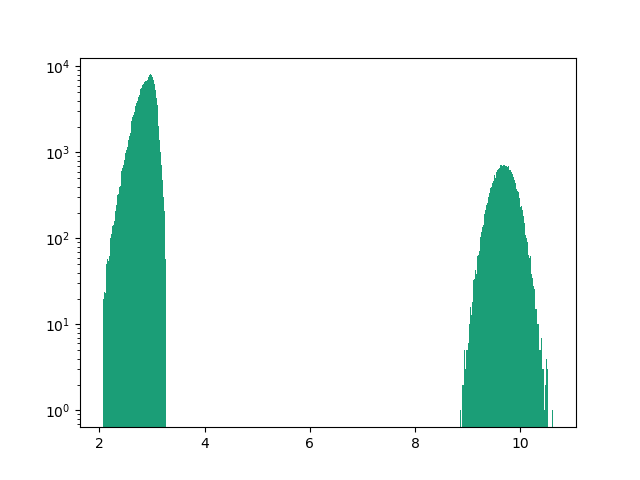

In [74]:
plt.figure()

plt.hist(cathode_events.kin_energy, bins = 500);
plt.semilogy()

Text(0, 0.5, 'Y [mm]')

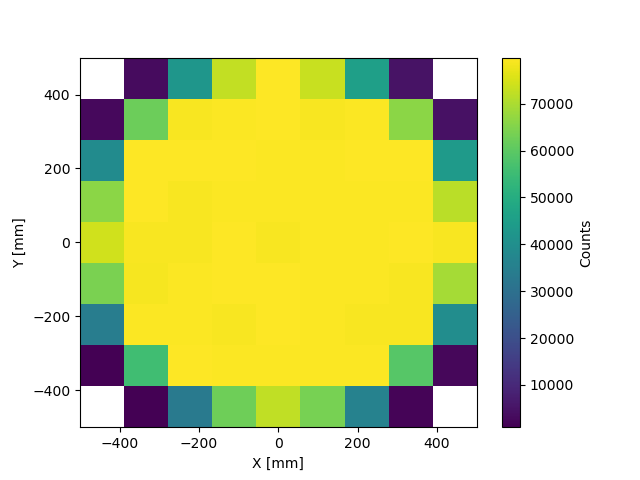

In [75]:
fig, ax = plt.subplots()
# plt.hist2d(cathode_events.initial_x, cathode_events.initial_y, bins = [np.linspace(-500,500, 10), np.linspace(-500,500, 10)]);
# plt.hist2d(parts.initial_x, parts.initial_y, bins = [np.linspace(-500,500, 10), np.linspace(-500,500, 10)]);


# hist, xedges, yedges = np.histogram2d(cathode_events.initial_x, cathode_events.initial_y, bins = [np.linspace(-500,500, 10), np.linspace(-500,500, 10)])
hist, xedges, yedges = np.histogram2d(parts.initial_x, parts.initial_y, bins = [np.linspace(-500,500, 10), np.linspace(-500,500, 10)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



In [97]:
print(cathode_events["bin_id"].unique())  # Check actual values
print([str(f"{x}_{y}")])  # Check formatted string


['2_3' '1_4' '7_2' '6_4' '2_6' '4_1' '3_7' '5_8' '6_5' '3_5' '7_7' '2_4'
 '4_0' '1_2' '6_3' '5_0' '3_2' '6_6' '7_6' '6_0' '4_7' '8_4' '4_8' '5_2'
 '6_2' '3_4' '7_3' '5_4' '5_7' '3_3' '4_2' '3_8' '2_5' '4_5' '7_4' '2_7'
 '4_4' '7_5' '1_8' '4_3' '2_1' '6_7' '1_5' '8_3' '1_1' '0_3' '5_6' '5_3'
 '5_1' '8_6' '1_6' '6_1' '4_6' '7_1' '1_3' '8_2' '3_1' '3_6' '8_5' '3_0'
 '0_6' '0_5' '5_5' '2_2' '1_7' '6_8' '2_8' '0_2' '0_4' '7_8' '2_0' '0_1'
 '7_0' '8_7' '0_7' '1_0' '8_1']
['8_0']


object


,event_id,x,y,z,kin_energy,mode,prevol,postvol,initial_x,initial_y,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
62,1825,240.48600,120.4900,1187.44,2.79700,Absorption,MESH_HOLE_GAS,CATHODE_GRID,-287.960999,408.664734,1,8,-333.333333,444.444444,1_8
3916,93593,73.74450,484.4480,1187.37,2.40723,Reflection,ACTIVE,CATHODE_GRID,-288.911591,393.973877,1,8,-333.333333,444.444444,1_8
4792,114168,100.30500,93.1481,1187.37,3.09643,Absorption,ACTIVE,CATHODE_GRID,-279.842865,392.818085,1,8,-333.333333,444.444444,1_8
5114,121927,3.10373,271.8630,1187.37,2.98042,Reflection,ACTIVE,CATHODE_GRID,-277.937927,393.408478,1,8,-333.333333,444.444444,1_8
5677,135741,277.34800,314.7140,1187.37,2.90194,Absorption,ACTIVE,CATHODE_GRID,-286.460663,397.056488,1,8,-333.333333,444.444444,1_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204894,4918687,208.79400,443.9960,1187.37,9.51550,Reflection,ACTIVE,CATHODE_GRID,-293.132660,400.199158,1,8,-333.333333,444.444444,1_8
205233,4926902,-349.51100,-46.0714,1187.38,2.99507,Absorption,MESH_HOLE_GAS,CATHODE_GRID,-290.043243,397.283417,1,8,-333.333333,444.444444,1_8
205642,4936131,-444.05200,38.4713,1187.37,2.75062,Absorption,ACTIVE,CATHODE_GRID,-298.790009,394.612183,1,8,-333.333333,444.444444,1_8
206686,4960774,378.76800,-303.8530,1187.37,3.11900,Absorption,ACTIVE,CATHODE_GRID,-300.908691,389.707947,1,8,-333.333333,444.444444,1_8


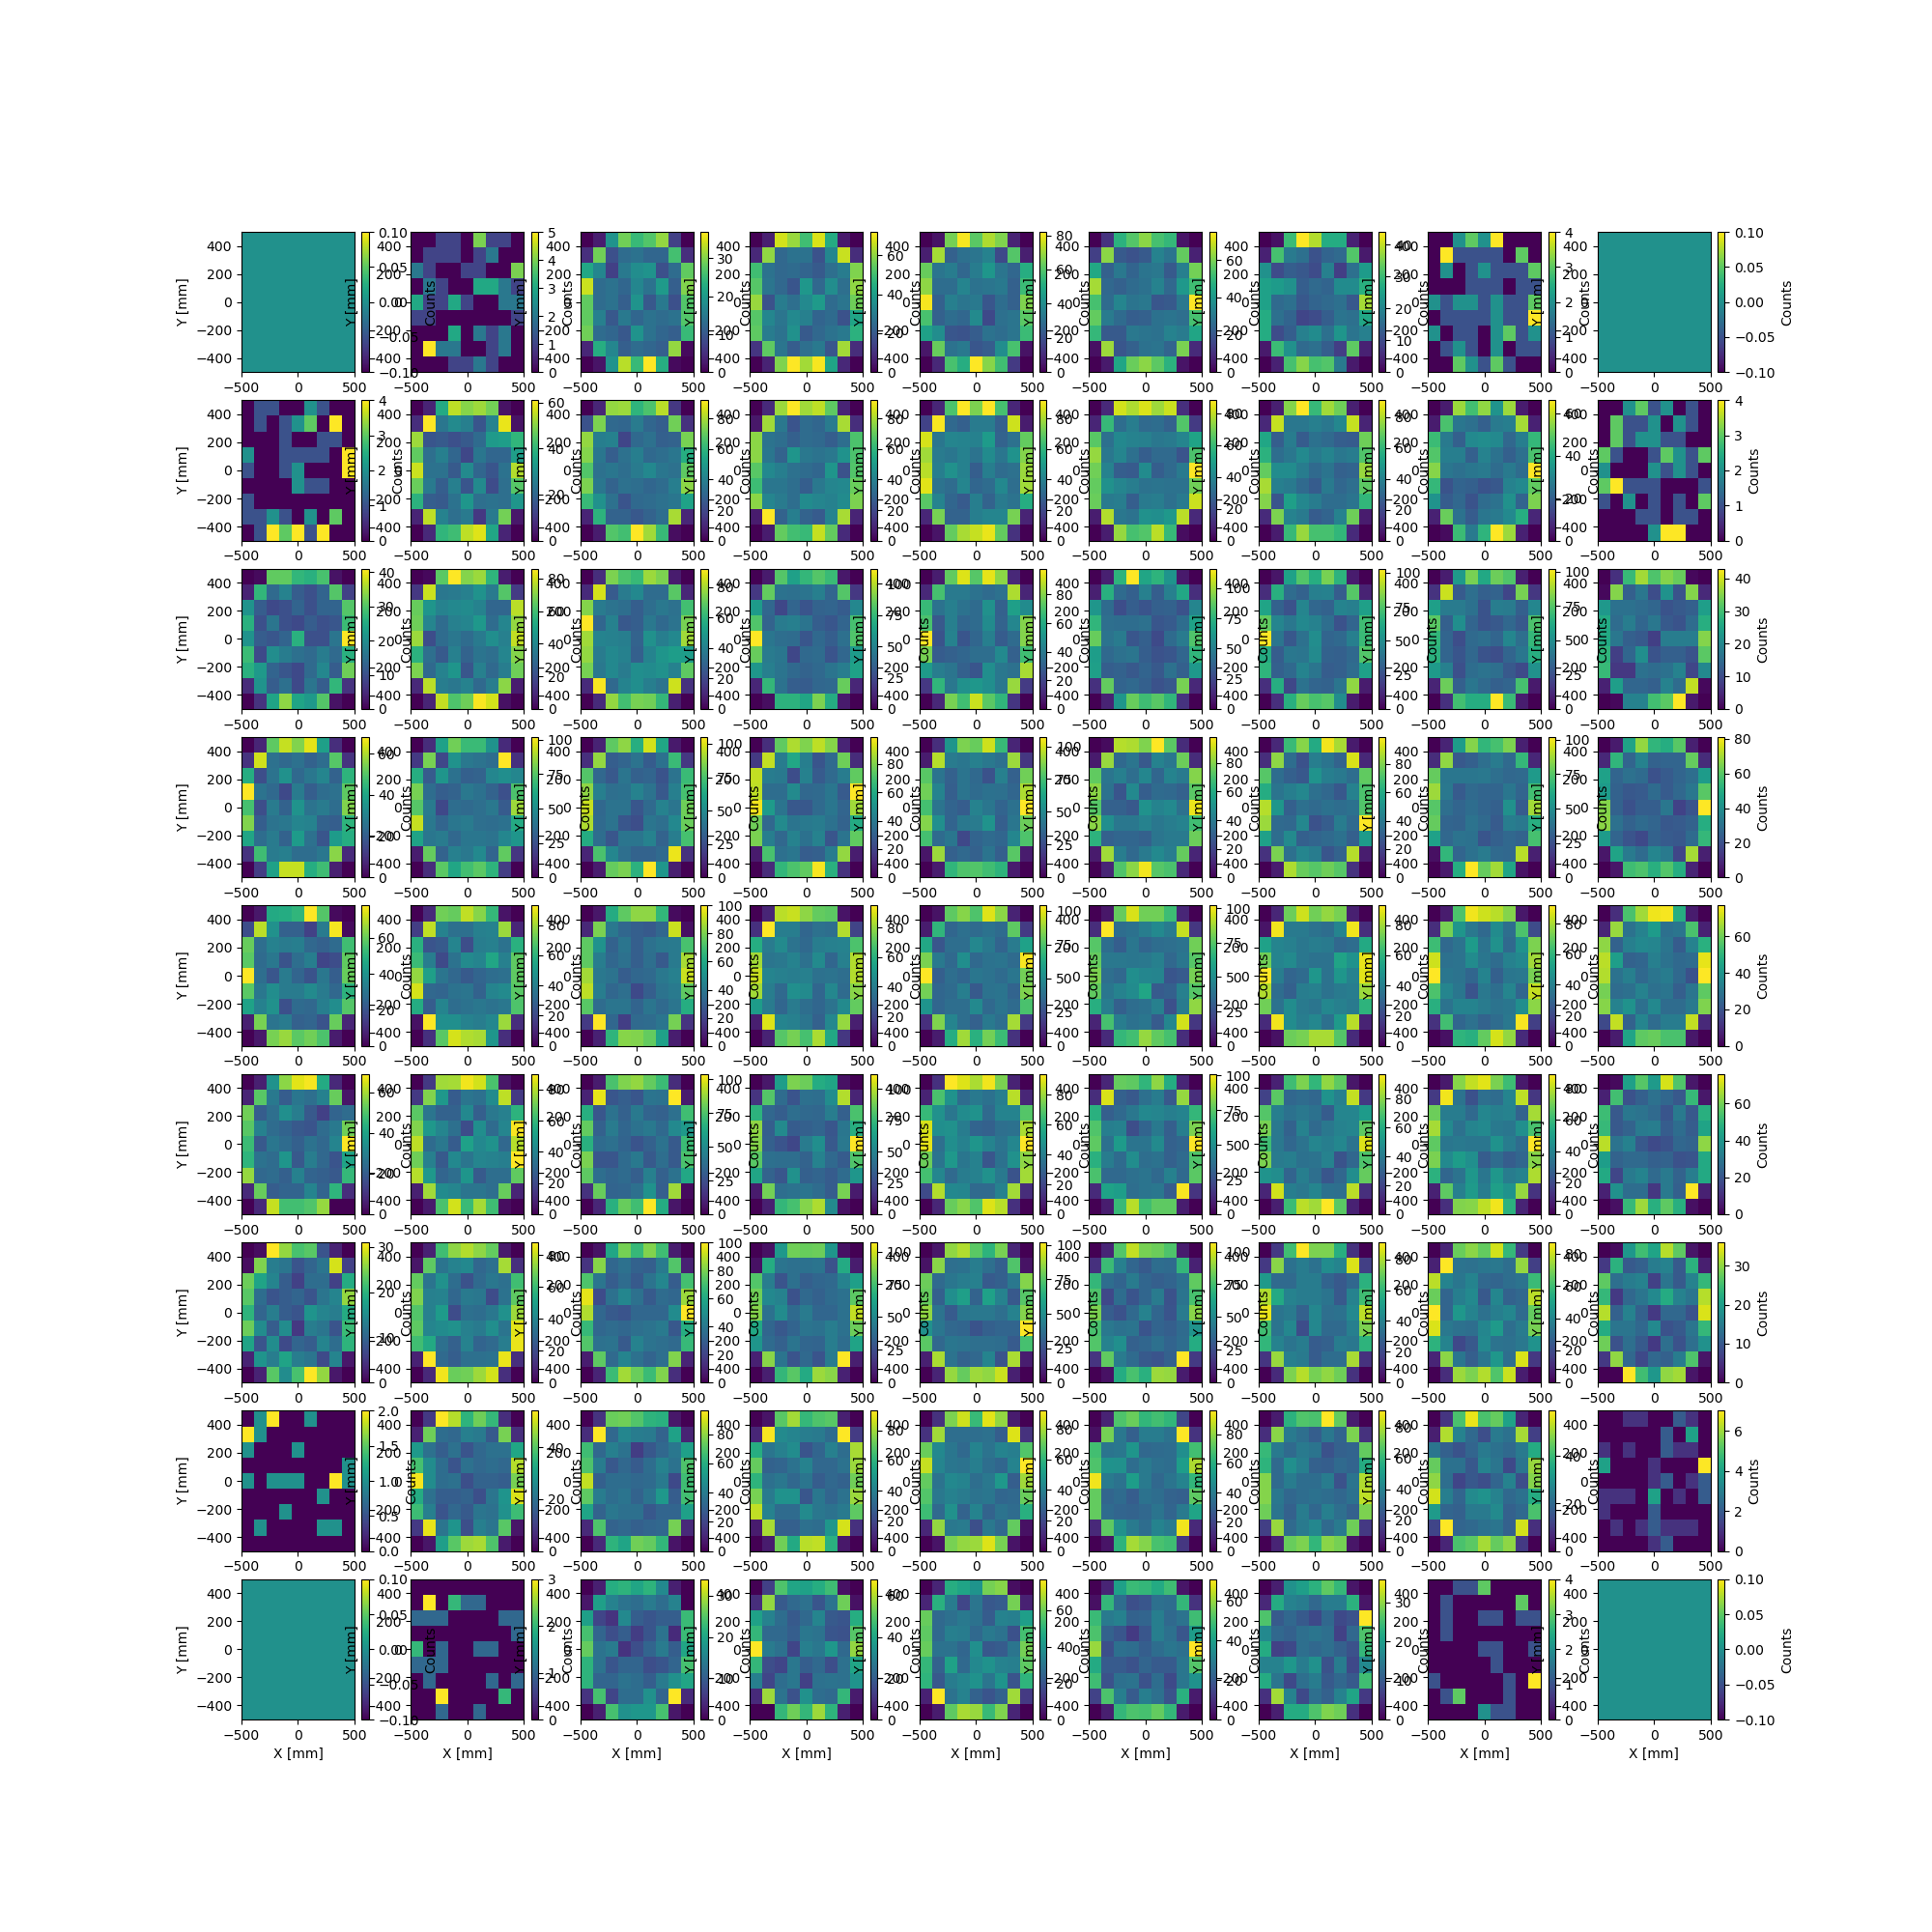

In [100]:
nbins=10

# Create a grid of subplots (5x5)
fig, axs = plt.subplots(nbins-1, nbins-1, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        

        df_bin = cathode_events[cathode_events.bin_id == f"{x}_{y}"]

        if (counter == 1):
            print(cathode_events["bin_id"].dtype)
            display(df_bin)

    
        # Plotting the fitted exponential decay curve
        hist, xedges, yedges = np.histogram2d(df_bin.x, df_bin.y, bins = [np.linspace(-500,500, 10), np.linspace(-500,500, 10)])

        # 2. Mask zero bins
        # masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

        # 3. Create a custom colormap with white for the masked values (zero bins)
        cmap = plt.cm.viridis  # Choose a colormap you like
        cmap.set_bad(color='white')  # Set masked values (zeros) to white

        # 4. Plot the 2D histogram

        pcm = axs[counter].pcolormesh(xedges, yedges, hist.T, cmap=cmap)

        # Add color bar
        plt.colorbar(pcm, ax=axs[counter], label='Counts')

        axs[counter].set_xlabel("X [mm]")
        axs[counter].set_ylabel("Y [mm]")

        counter=counter+1

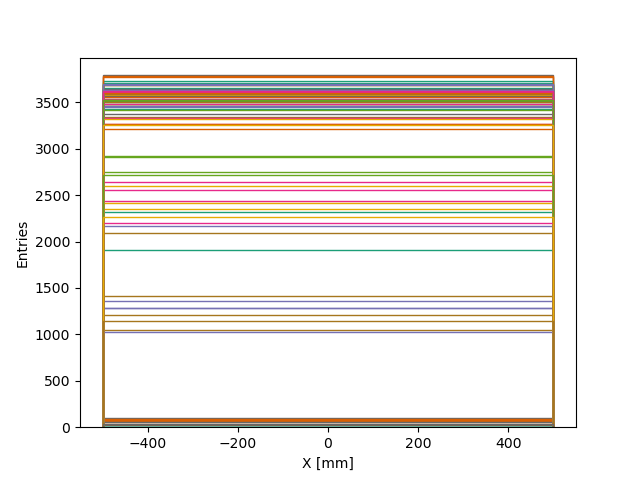

In [104]:
nbins=10

# Create a grid of subplots (5x5)
plt.figure()

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        
        df_bin = cathode_events[cathode_events.bin_id == f"{x}_{y}"]
        # Plotting the fitted exponential decay curve
        plt.hist(df_bin.x, bins = np.linspace(-500,500, 2), histtype="step")
        plt.xlabel("X [mm]")
        plt.ylabel("Entries")


,event_id,x,y,z,kin_energy,mode,prevol,postvol,initial_x,initial_y
0,70,362.8980,274.3900,1187.40,2.50677,Reflection,MESH_HOLE_GAS,CATHODE_GRID,-255.558350,-96.163712
10,359,-435.5890,-84.7100,1187.43,2.55573,Reflection,MESH_HOLE_GAS,CATHODE_GRID,62.682274,476.090851
16,527,-78.3782,397.5150,1187.39,2.86818,Absorption,MESH_HOLE_GAS,CATHODE_GRID,-34.972721,-389.891357
19,651,250.9140,-196.5250,1187.48,3.06528,Reflection,MESH_HOLE_GAS,CATHODE_GRID,158.513306,-400.014526
22,699,-279.0830,261.5650,1187.46,2.94196,Absorption,MESH_HOLE_GAS,CATHODE_GRID,325.610352,274.821594
...,...,...,...,...,...,...,...,...,...,...
208308,4999667,-437.5040,39.7099,1187.50,2.75473,Reflection,MESH_HOLE_GAS,CATHODE_GRID,286.099274,-41.871307
208310,4999672,-143.0510,197.4400,1187.39,3.08129,Reflection,MESH_HOLE_GAS,CATHODE_GRID,-405.231201,-81.788071
208312,4999701,46.4777,-70.1117,1187.43,2.98974,Absorption,MESH_HOLE_GAS,CATHODE_GRID,324.314392,-0.715386
208317,4999824,39.0301,323.1250,1187.37,2.70104,Reflection,MESH_HOLE_GAS,CATHODE_GRID,213.074570,-172.662628


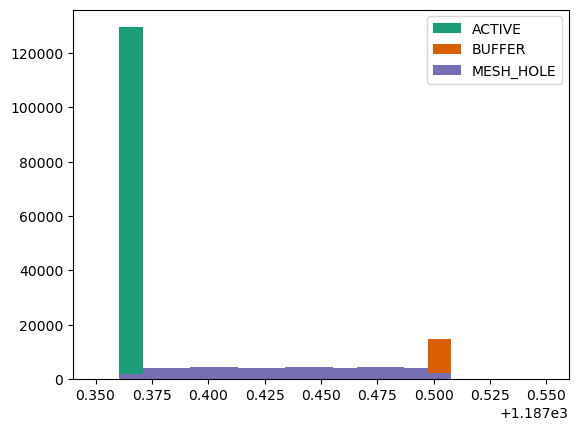

In [13]:
filt_active = cathode_events [cathode_events.prevol == "ACTIVE"]
filt_buffer = cathode_events [cathode_events.prevol == "BUFFER"]
filt_hole   = cathode_events [cathode_events.prevol == "MESH_HOLE_GAS"]

display(filt_hole)

plt.hist(filt_active.z, bins = np.linspace(1187.35,1187.55,20), label = "ACTIVE");
plt.hist(filt_buffer.z, bins = np.linspace(1187.35,1187.55,20), label = "BUFFER");
plt.hist(filt_hole.z, bins = np.linspace(1187.35,1187.55,20), label = "MESH_HOLE");
plt.legend()

VISIBLE
Visible ACTIVE: ( 59.4 %)
Visible HOLE: ( 28.53 %)
Visible BUFFER: ( 7.69 %)

VUV
Visible ACTIVE: ( 83.88 %)
Visible HOLE: ( 10.57 %)
Visible BUFFER: ( 2.65 %)


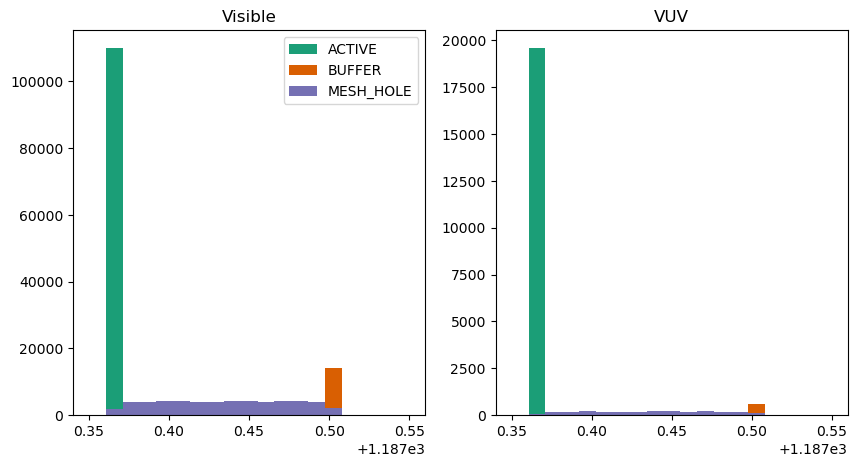

In [14]:
filt_active_vis = cathode_events [(cathode_events.prevol == "ACTIVE") & (cathode_events.kin_energy < 5)]
filt_buffer_vis = cathode_events [(cathode_events.prevol == "BUFFER") & (cathode_events.kin_energy < 5)]
filt_hole_vis   = cathode_events [(cathode_events.prevol == "MESH_HOLE_GAS") & (cathode_events.kin_energy < 5)]

print("VISIBLE")
print("Visible ACTIVE:", "(", round(100*len(filt_active_vis)/tot_vis,2), "%)")
print("Visible HOLE:",   "(", round(100*len(filt_hole_vis)/tot_vis,2), "%)")
print("Visible BUFFER:", "(", round(100*len(filt_buffer_vis)/tot_vis,2), "%)")


filt_active_vuv = cathode_events [(cathode_events.prevol == "ACTIVE") & (cathode_events.kin_energy > 5)]
filt_buffer_vuv = cathode_events [(cathode_events.prevol == "BUFFER") & (cathode_events.kin_energy > 5)]
filt_hole_vuv   = cathode_events [(cathode_events.prevol == "MESH_HOLE_GAS") & (cathode_events.kin_energy > 5)]

print("\nVUV")
print("Visible ACTIVE:", "(", round(100*len(filt_active_vuv)/tot_vuv,2), "%)")
print("Visible HOLE:",   "(", round(100*len(filt_hole_vuv)/tot_vuv,2), "%)")
print("Visible BUFFER:", "(", round(100*len(filt_buffer_vuv)/tot_vuv,2), "%)")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(filt_active_vis.z, bins = np.linspace(1187.35,1187.55,20), label = "ACTIVE");
axs[0].hist(filt_buffer_vis.z, bins = np.linspace(1187.35,1187.55,20), label = "BUFFER");
axs[0].hist(filt_hole_vis.z, bins = np.linspace(1187.35,1187.55,20), label = "MESH_HOLE");
axs[0].legend()
axs[0].set_title("Visible");

axs[1].hist(filt_active_vuv.z, bins = np.linspace(1187.35,1187.55,20), label = "ACTIVE");
axs[1].hist(filt_buffer_vuv.z, bins = np.linspace(1187.35,1187.55,20), label = "BUFFER");
axs[1].hist(filt_hole_vuv.z, bins = np.linspace(1187.35,1187.55,20), label = "MESH_HOLE");
axs[1].set_title("VUV");

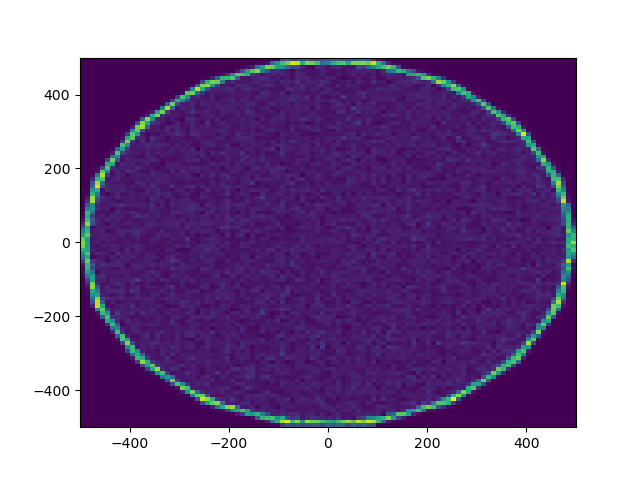

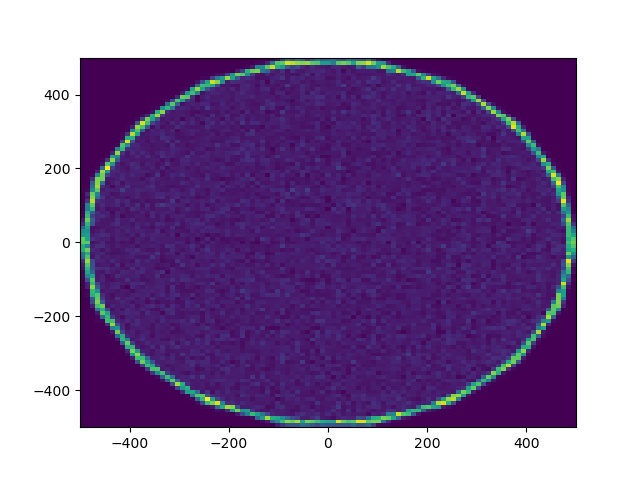

In [26]:
%matplotlib widget
# Plot the final x,y positions
plt.figure()
plt.hist2d(cathode_events[cathode_events["mode"] == "Absorption"].x, cathode_events[cathode_events["mode"] == "Absorption"].y, bins = [np.linspace(-500,500, 100), np.linspace(-500,500, 100)]);

# The boader effect in the active is due to the mesh boarder exteding to the ring thickness. We are essentially seeing reflections on the ring. 


plt.figure()
plt.hist2d(cathode_events[cathode_events["mode"] == "Reflection"].x, cathode_events[cathode_events["mode"] == "Reflection"].y, bins = [np.linspace(-500,500, 100), np.linspace(-500,500, 100)]);

